In [6]:
import numpy as np
import sys
sys.path.append('../../otf/otf_engine')
import gp, env, struc, kernels, otf
sys.path.append('../../otf/modules')
import qe_parsers, analyze_gp, parse_output_temp, otf_parser, calculate_rdf, \
    analyze_otf, crystals, activation_parser, analyze_md, otf_parser_v2, analyze_gp_v2
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy

# return to default and make the fontbigger
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

# Quench Figure

In [2]:
file_name = '/Users/jonpvandermause/Research/GP/otf/datasets/Quench_Runs/Al_Quench_5ps_2-23/otf_run.out'
otf_run = otf_parser_v2.OtfAnalysis(file_name)

In [3]:
# record msd and dft calls
end = 130

quench_times = otf_run.times[0 : end]
quench_msds = otf_run.msds[0 : end]

In [4]:
# get otf times and msds
dft_times_plot = otf_run.dft_times[1:-1]
dft_msds_plot = []
for time in dft_times_plot:
    ind = otf_run.times.index(time)
    dft_msds_plot.append(otf_run.msds[ind])

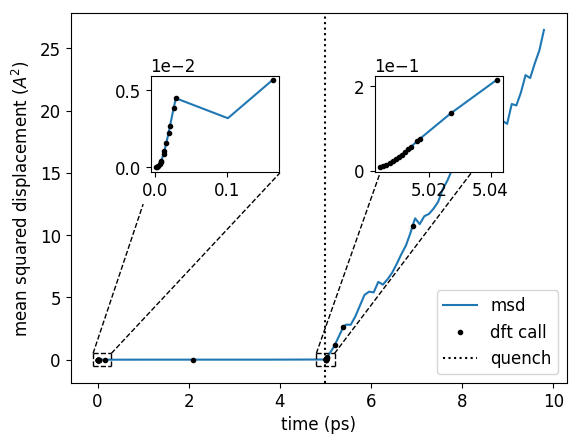

In [12]:
# make figure
f, ax1 = plt.subplots(1, 1)

# plot vertical line for every dft call
ax1.plot(quench_times, quench_msds, label='msd')

ax1.plot(dft_times_plot, dft_msds_plot, 'k.', label='dft call')
ax1.axvline(5, color='k', linestyle=':', label='quench')

# solid subplot
ax2 = plt.axes([.25, .55, .2, .2])
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(quench_times[0 : 15], quench_msds[0:15])
ax2.plot(dft_times_plot[0:14], dft_msds_plot[0:14], 'k.', label='dft call')

# solid dotted box
left = -0.1
right = 0.3
down = -0.5
up = 0.5
ax1.plot([left, right], [up, up], 'k--', linewidth=1)
ax1.plot([left, right], [down, down], 'k--', linewidth=1)
ax1.plot([left, left], [down, up], 'k--', linewidth=1)
ax1.plot([right, right], [down, up], 'k--', linewidth=1)

ax1.plot([left, 1], [up, 12.5], 'k--', linewidth=1)
ax1.plot([right, 4], [up, 15], 'k--', linewidth=1)

# liquid subplot
ax3 = plt.axes([.6, .55, .2, .2])
ax3.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax3.plot(quench_times[64 : 79], quench_msds[64 : 79])
ax3.plot(dft_times_plot[15:30], dft_msds_plot[15:30], 'k.', label='dft call')

# liquid dotted box
left = 4.8
right = 5.2
down = -0.5
up = 0.5
ax1.plot([left, right], [up, up], 'k--', linewidth=1)
ax1.plot([left, right], [down, down], 'k--', linewidth=1)
ax1.plot([left, left], [down, up], 'k--', linewidth=1)
ax1.plot([right, right], [down, up], 'k--', linewidth=1)

ax1.plot([left, 6.2], [up, 15], 'k--', linewidth=1)
ax1.plot([right, 8.2], [up, 15], 'k--', linewidth=1)


ax1.set_xlabel('time (ps)')
ax1.set_ylabel('mean squared displacement ($A^2$)')


ax1.legend(loc='lower right')


f.savefig('melt_msd_3.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [119]:
otf_run.dft_times

[0.0,
 0.002,
 0.003,
 0.005,
 0.007,
 0.008,
 0.009,
 0.012,
 0.013,
 0.016,
 0.019,
 0.021,
 0.026,
 0.029,
 0.163,
 2.087,
 5.004,
 5.005,
 5.006,
 5.007,
 5.008,
 5.009,
 5.01,
 5.011,
 5.012,
 5.013,
 5.014,
 5.016,
 5.017,
 5.027,
 5.042,
 5.204,
 5.384,
 6.913,
 25.109]

In [101]:
quench_times.index(5.042)

78

In [105]:
quench_times.index(4.949)

63

In [104]:
quench_times

[0.002,
 0.003,
 0.005,
 0.007,
 0.008,
 0.009,
 0.012,
 0.013,
 0.016,
 0.019,
 0.021,
 0.026,
 0.029,
 0.101,
 0.163,
 0.202,
 0.303,
 0.404,
 0.505,
 0.606,
 0.707,
 0.808,
 0.909,
 1.01,
 1.111,
 1.212,
 1.313,
 1.414,
 1.515,
 1.616,
 1.717,
 1.818,
 1.919,
 2.02,
 2.087,
 2.121,
 2.222,
 2.323,
 2.424,
 2.525,
 2.626,
 2.727,
 2.828,
 2.929,
 3.03,
 3.131,
 3.232,
 3.333,
 3.434,
 3.535,
 3.636,
 3.737,
 3.838,
 3.939,
 4.04,
 4.141,
 4.242,
 4.343,
 4.444,
 4.545,
 4.646,
 4.747,
 4.848,
 4.949,
 5.004,
 5.005,
 5.006,
 5.007,
 5.008,
 5.009,
 5.01,
 5.011,
 5.012,
 5.013,
 5.014,
 5.016,
 5.017,
 5.027,
 5.042,
 5.05,
 5.151,
 5.204,
 5.252,
 5.353,
 5.384,
 5.454,
 5.555,
 5.656,
 5.757,
 5.858,
 5.959,
 6.06,
 6.161,
 6.262,
 6.363,
 6.464,
 6.565,
 6.666,
 6.767,
 6.868,
 6.913,
 6.969,
 7.07,
 7.171,
 7.272,
 7.373,
 7.474,
 7.575,
 7.676,
 7.777,
 7.878,
 7.979,
 8.08,
 8.181,
 8.282,
 8.383,
 8.484,
 8.585,
 8.686,
 8.787,
 8.888,
 8.989,
 9.09,
 9.191,
 9.292,
 9.393,
 9

In [91]:
dft_times_plot

[0.002,
 0.003,
 0.005,
 0.007,
 0.008,
 0.009,
 0.012,
 0.013,
 0.016,
 0.019,
 0.021,
 0.026,
 0.029,
 0.163,
 2.087,
 5.004,
 5.005,
 5.006,
 5.007,
 5.008,
 5.009,
 5.01,
 5.011,
 5.012,
 5.013,
 5.014,
 5.016,
 5.017,
 5.027,
 5.042,
 5.204,
 5.384]

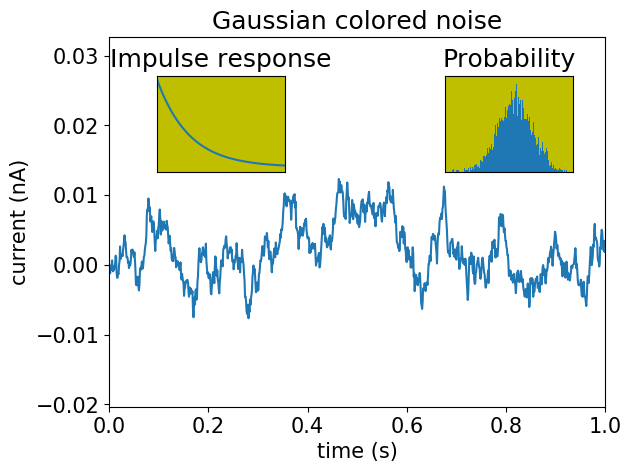

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# create some data to use for the plot
dt = 0.001
t = np.arange(0.0, 10.0, dt)
r = np.exp(-t[:1000]/0.05)               # impulse response
x = np.random.randn(len(t))
s = np.convolve(x, r)[:len(x)]*dt  # colored noise

# the main axes is subplot(111) by default
plt.plot(t, s)
plt.axis([0, 1, 1.1*np.amin(s), 2*np.amax(s)])
plt.xlabel('time (s)')
plt.ylabel('current (nA)')
plt.title('Gaussian colored noise')

# this is an inset axes over the main axes
a = plt.axes([.65, .6, .2, .2], facecolor='y')
n, bins, patches = plt.hist(s, 400, normed=1)
plt.title('Probability')
plt.xticks([])
plt.yticks([])

# this is another inset axes over the main axes
a = plt.axes([0.2, 0.6, .2, .2], facecolor='y')
plt.plot(t[:len(r)], r)
plt.title('Impulse response')
plt.xlim(0, 0.2)
plt.xticks([])
plt.yticks([])

plt.show()

880


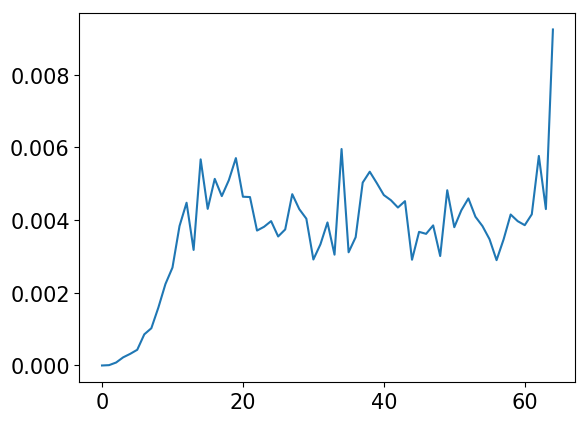

In [79]:
print(len(otf_run.msds))
plt.plot(otf_run.msds[0:65])
plt.show()

In [80]:
# calculate solid rdf
position_list = otf_run.position_list
cell = 8.092 * np.eye(3)
species = ['Al']*32
snaps = np.arange(0, 60, 1)
cutoff = 8.092
bins = 200

sol_rs, sol_rad_dist, sol_atom_count = \
    calculate_rdf.calculate_rdf(position_list, cell, species, snaps, cutoff, bins)

# calculate liquid rdf
position_list = otf_run.position_list
cell = 8.092 * np.eye(3)
species = ['Al']*32
snaps = np.arange(100, 880, 1)
cutoff = 8.092
bins = 200

liq_rs, liq_rad_dist, liq_atom_count = \
    calculate_rdf.calculate_rdf(position_list, cell, species, snaps, cutoff, bins)

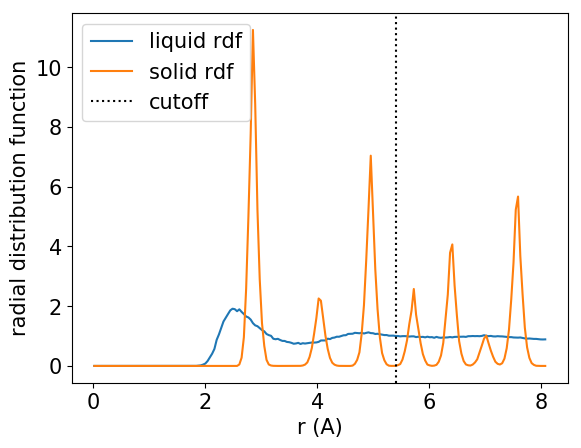

In [83]:
# plot rdf
f, (ax1) = plt.subplots(1, 1)
ax1.plot(liq_rs, liq_rad_dist, label='liquid rdf')
ax1.plot(sol_rs, sol_rad_dist, label='solid rdf')
ax1.set_xlabel('r (A)')
ax1.set_ylabel('radial distribution function')
ax1.axvline(5.4, color='k', linestyle=':', label='cutoff')
ax1.legend()

f.savefig('rdf.pdf', format='pdf',bbox_inches='tight')
plt.show()

In [30]:
# record uncertainties
mean_stds = []
max_stds = []

for std in otf_run.uncertainty_list:
    mean_stds.append(np.mean(std))
    max_stds.append(np.max(std))
    
mean_stds = np.array(mean_stds)
max_stds = np.array(max_stds)

plot_max_stds = max_stds[0 : end]
plot_mean_stds = mean_stds[0 :end]

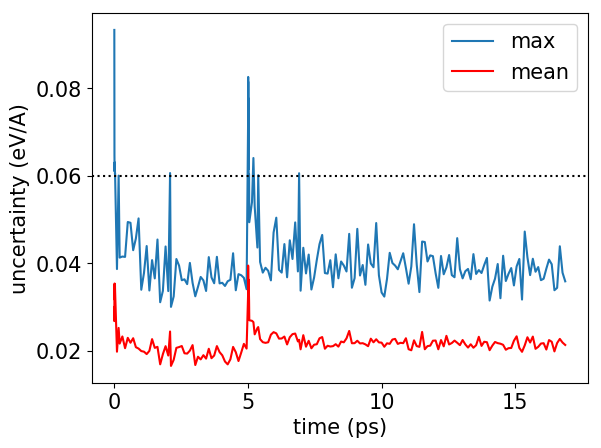

In [31]:
# plot uncertainties
f = plt.figure()
plt.plot(quench_times, plot_max_stds, label='max')
plt.plot(quench_times, plot_mean_stds, color='r', label='mean')
plt.axhline(0.06, color='k', linestyle=':')
plt.xlabel('time (ps)')
plt.ylabel('uncertainty (eV/A)')
plt.legend()

f.savefig('uncertainty.pdf', format='pdf',bbox_inches='tight')
plt.show()